In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
# !git pull

In [3]:
import tensorflow as tf
import malaya_speech
import malaya_speech.train
from malaya_speech.train.model import fastspeech2
import numpy as np






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
_pad = 'pad'
_start = 'start'
_eos = 'eos'
_punctuation = "!'(),.:;? "
_special = '-'
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

MALAYA_SPEECH_SYMBOLS = (
    [_pad, _start, _eos] + list(_special) + list(_punctuation) + list(_letters)
)

In [5]:
input_ids = tf.placeholder(tf.int32, [None, None])
lens = tf.placeholder(tf.int32, [None, None])
mel_outputs = tf.placeholder(tf.float32, [None, None, 80])
mel_lengths = tf.placeholder(tf.int32, [None])
energies = tf.placeholder(tf.float32, [None, None])
energies_lengths = tf.placeholder(tf.int32, [None])
f0s = tf.placeholder(tf.float32, [None, None])
f0s_lengths = tf.placeholder(tf.int32, [None])

In [6]:
config = malaya_speech.config.fastspeech2_config
config = fastspeech2.Config(
    vocab_size = len(MALAYA_SPEECH_SYMBOLS), **config
)
model = fastspeech2.Model(config)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
r_training = model(input_ids, lens, f0s, energies, training = False)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
speed_ratios = tf.placeholder(tf.float32, [None], name = 'speed_ratios')
f0_ratios = tf.placeholder(tf.float32, [None], name = 'f0_ratios')
energy_ratios = tf.placeholder(tf.float32, [None], name = 'energy_ratios')

r = model.inference(input_ids, speed_ratios, f0_ratios, energy_ratios)

In [9]:
r

(<tf.Tensor 'mel_before/BiasAdd:0' shape=(?, ?, 80) dtype=float32>,
 <tf.Tensor 'add_3:0' shape=(?, ?, 80) dtype=float32>,
 <tf.Tensor 'Cast:0' shape=(?, ?) dtype=int32>,
 <tf.Tensor 'mul_1:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'mul_2:0' shape=(?, ?) dtype=float32>)

In [10]:
decoder_output = tf.identity(r[0], name = 'decoder_output')
post_mel_outputs = tf.identity(r[1], name = 'post_mel_outputs')

In [11]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [12]:
path = 'fastspeech2-husein'
ckpt_path = tf.train.latest_checkpoint(path)
ckpt_path

'fastspeech2-husein/model.ckpt-156000'

In [13]:
saver = tf.train.Saver()
saver.restore(sess, ckpt_path)

INFO:tensorflow:Restoring parameters from fastspeech2-husein/model.ckpt-156000


In [17]:
import re
from unidecode import unidecode
import malaya

# Regular expression matching text enclosed in curly braces:
_curly_re = re.compile(r"(.*?)\{(.+?)\}(.*)")

normalizer = malaya.normalize.normalizer(date = False, time = False)
pad_to = 8

def tts_encode(string: str, add_eos: bool = True):
    r = [MALAYA_SPEECH_SYMBOLS.index(c) for c in string if c in MALAYA_SPEECH_SYMBOLS]
    if add_eos:
        r = r + [MALAYA_SPEECH_SYMBOLS.index('eos')]
    return r

def put_spacing_num(string):
    string = re.sub('[A-Za-z]+', lambda ele: ' ' + ele[0] + ' ', string)
    return re.sub(r'[ ]+', ' ', string).strip()

def convert_to_ascii(string):
    return unidecode(string)

def collapse_whitespace(string):
    return re.sub(_whitespace_re, ' ', string)

def cleaning(string, normalize = True, add_eos = True):
    sequence = []
    string = convert_to_ascii(string)
    string = string.replace('&', ' dan ')
    if normalize:
        string = normalizer.normalize(string, 
                                      check_english = False, 
                                      normalize_entity = False, 
                                      normalize_text = False,
                                      normalize_url = True,
                                      normalize_email = True)
        string = string['normalize']
    else:
        string = string
    string = string.lower()
    string = put_spacing_num(string)
    string = re.sub(r'[ ]+', ' ', string).strip()
    ids = tts_encode(string, add_eos = add_eos)
    text_input = np.array(ids)
    num_pad = pad_to - ((len(text_input) + 2) % pad_to)
    text_input = np.pad(
        text_input, ((1, 1)), 'constant', constant_values = ((1, 2))
    )
    text_input = np.pad(
        text_input, ((0, num_pad)), 'constant', constant_values = 0
    )
    
    return string, text_input

In [18]:
import matplotlib.pyplot as plt

In [19]:
# https://umno-online.my/2020/12/28/isu-kartel-daging-haram-lagi-pihak-gesa-kerajaan-ambil-tindakan-tegas-drastik/

t, ids = cleaning('Pergerakan Pemuda UMNO Negeri Perak mendesak agar tindakan drastik dan tegas diambil dalam kadar segera bersesuaian dengan enam saranan yang telah dibentangkan oleh Pergerakan Pemuda UMNO sebelum ini berhubung isu kartel daging haram.', add_eos = False)
t, ids

('pergerakan pemuda umno negeri perak mendesak agar tindakan drastik dan tegas diambil dalam kadar segera bersesuaian dengan enam saranan yang telah dibentangkan oleh pergerakan pemuda umno sebelum ini berhubung isu kartel daging haram .',
 array([ 1, 55, 44, 57, 46, 44, 57, 40, 50, 40, 53, 13, 55, 44, 52, 60, 43,
        40, 13, 60, 52, 53, 54, 13, 53, 44, 46, 44, 57, 48, 13, 55, 44, 57,
        40, 50, 13, 52, 44, 53, 43, 44, 58, 40, 50, 13, 40, 46, 40, 57, 13,
        59, 48, 53, 43, 40, 50, 40, 53, 13, 43, 57, 40, 58, 59, 48, 50, 13,
        43, 40, 53, 13, 59, 44, 46, 40, 58, 13, 43, 48, 40, 52, 41, 48, 51,
        13, 43, 40, 51, 40, 52, 13, 50, 40, 43, 40, 57, 13, 58, 44, 46, 44,
        57, 40, 13, 41, 44, 57, 58, 44, 58, 60, 40, 48, 40, 53, 13, 43, 44,
        53, 46, 40, 53, 13, 44, 53, 40, 52, 13, 58, 40, 57, 40, 53, 40, 53,
        13, 64, 40, 53, 46, 13, 59, 44, 51, 40, 47, 13, 43, 48, 41, 44, 53,
        59, 40, 53, 46, 50, 40, 53, 13, 54, 51, 44, 47, 13, 55, 44, 57, 46,


In [20]:
# https://www.hmetro.com.my/mutakhir/2020/12/657604/6-cadangan-tangani-kelemahan-kawal-selia-halal

t, ids = cleaning('Haqkiem adalah pelajar tahun akhir yang mengambil Ijazah Sarjana Muda Sains Komputer Kecerdasan Buatan utama dari Universiti Teknikal Malaysia Melaka (UTeM) yang kini berusaha untuk latihan industri di mana dia secara praktikal dapat menerapkan pengetahuannya dalam Perisikan Perisian dan Pengaturcaraan ke arah organisasi atau industri yang berkaitan.', add_eos = False)
t, ids

('haqkiem adalah pelajar tahun akhir yang mengambil ijazah sarjana muda sains komputer kecerdasan buatan utama dari universiti teknikal malaysia melaka ( utem ) yang kini berusaha untuk latihan industri di mana dia secara praktikal dapat menerapkan pengetahuannya dalam perisikan perisian dan pengaturcaraan ke arah organisasi atau industri yang berkaitan .',
 array([ 1, 47, 40, 56, 50, 48, 44, 52, 13, 40, 43, 40, 51, 40, 47, 13, 55,
        44, 51, 40, 49, 40, 57, 13, 59, 40, 47, 60, 53, 13, 40, 50, 47, 48,
        57, 13, 64, 40, 53, 46, 13, 52, 44, 53, 46, 40, 52, 41, 48, 51, 13,
        48, 49, 40, 65, 40, 47, 13, 58, 40, 57, 49, 40, 53, 40, 13, 52, 60,
        43, 40, 13, 58, 40, 48, 53, 58, 13, 50, 54, 52, 55, 60, 59, 44, 57,
        13, 50, 44, 42, 44, 57, 43, 40, 58, 40, 53, 13, 41, 60, 40, 59, 40,
        53, 13, 60, 59, 40, 52, 40, 13, 43, 40, 57, 48, 13, 60, 53, 48, 61,
        44, 57, 58, 48, 59, 48, 13, 59, 44, 50, 53, 48, 50, 40, 51, 13, 52,
        40, 51, 40, 64, 58, 48, 

In [21]:
%%time

o = sess.run([decoder_output, post_mel_outputs], feed_dict = {input_ids: [ids], 
                             speed_ratios: [1.0],
                             f0_ratios: [1.0], 
                             energy_ratios: [1.0]})

CPU times: user 4.68 s, sys: 464 ms, total: 5.15 s
Wall time: 590 ms


In [22]:
o[1].shape

(1, 1962, 80)

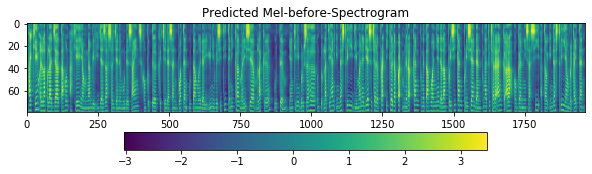

In [23]:
mel_outputs_ = np.reshape(o[1], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

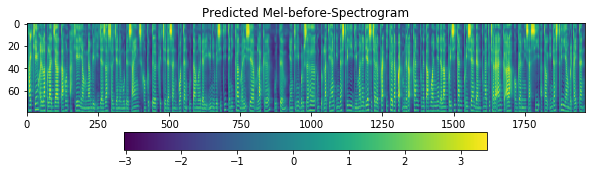

In [24]:
mel_outputs_ = np.reshape(o[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [25]:
import pickle

with open('a.pkl', 'wb') as fopen:
    pickle.dump([np.reshape(o[0], [-1, 80]), np.reshape(o[1], [-1, 80])], fopen)

In [26]:
saver = tf.train.Saver()
saver.save(sess, 'fastspeech2-husein-output/model.ckpt')

'fastspeech2-husein-output/model.ckpt'

In [27]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'gather' in n.op.lower()
        or 'Placeholder' in n.name
        or 'ratios' in n.name
        or 'post_mel_outputs' in n.name
        or 'decoder_output' in n.name
        or 'alignment_histories' in n.name)
        and 'adam' not in n.name
        and 'global_step' not in n.name
        and 'Assign' not in n.name
        and 'ReadVariableOp' not in n.name
        and 'Gather' not in n.name
        and 'IsVariableInitialized' not in n.name
    ]
)
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Placeholder_2',
 'Placeholder_3',
 'Placeholder_4',
 'Placeholder_5',
 'Placeholder_6',
 'Placeholder_7',
 'weight',
 'model/embeddings/position_embeddings/Placeholder',
 'model/decoder/position_embeddings/Placeholder',
 'speed_ratios',
 'f0_ratios',
 'energy_ratios',
 'decoder_output',
 'post_mel_outputs']

In [28]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [29]:
freeze_graph('fastspeech2-husein-output', strings)

INFO:tensorflow:Restoring parameters from fastspeech2-husein-output/model.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 187 variables.
INFO:tensorflow:Converted 187 variables to const ops.
2896 ops in the final graph.


In [30]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
                
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
        
    return graph

In [31]:
g = load_graph('fastspeech2-husein-output/frozen_model.pb')

In [32]:
test_sess = tf.InteractiveSession(graph = g)

In [33]:
X = g.get_tensor_by_name('import/Placeholder:0')
speed_ratios = g.get_tensor_by_name('import/speed_ratios:0')
f0_ratios = g.get_tensor_by_name('import/f0_ratios:0')
energy_ratios = g.get_tensor_by_name('import/energy_ratios:0')

In [34]:
output_nodes = ['decoder_output', 'post_mel_outputs']
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}

In [35]:
%%time

o = test_sess.run(outputs, feed_dict = {X: [ids], 
                             speed_ratios: [1.0],
                             f0_ratios: [1.0], 
                             energy_ratios: [1.0]})

CPU times: user 4.75 s, sys: 506 ms, total: 5.25 s
Wall time: 730 ms


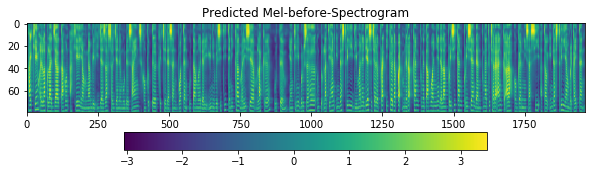

In [36]:
mel_outputs_ = np.reshape(o['decoder_output'], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

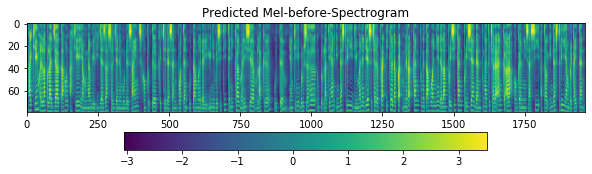

In [37]:
mel_outputs_ = np.reshape(o['post_mel_outputs'], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [38]:
from tensorflow.tools.graph_transforms import TransformGraph

In [39]:
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-1024, fallback_max=1024)',
             'strip_unused_nodes',
             'sort_by_execution_order']

In [40]:
pb = 'fastspeech2-husein-output/frozen_model.pb'

In [41]:
input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

transformed_graph_def = TransformGraph(input_graph_def, 
                                           ['Placeholder', 'speed_ratios', 'f0_ratios', 'energy_ratios'],
                                           output_nodes, transforms)
    
with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

Instructions for updating:
Use tf.gfile.GFile.


In [42]:
g = load_graph('fastspeech2-husein-output/frozen_model.pb.quantized')

In [43]:
b2_application_key_id = os.environ['b2_application_key_id']
b2_application_key = os.environ['b2_application_key']

In [44]:
from b2sdk.v1 import *
info = InMemoryAccountInfo()
b2_api = B2Api(info)
application_key_id = b2_application_key_id
application_key = b2_application_key
b2_api.authorize_account("production", application_key_id, application_key)
file_info = {'how': 'good-file'}
b2_bucket = b2_api.get_bucket_by_name('malaya-speech-model')

In [45]:
file = 'fastspeech2-husein-output/frozen_model.pb'
outPutname = 'v2/tts/fastspeech2-husein.pb'
b2_bucket.upload_local_file(
    local_file=file,
    file_name=outPutname,
    file_infos=file_info,
)

In [46]:
file = 'fastspeech2-husein-output/frozen_model.pb.quantized'
outPutname = 'v2/tts/fastspeech2-husein.pb.quantized'
b2_bucket.upload_local_file(
    local_file=file,
    file_name=outPutname,
    file_infos=file_info,
)

In [47]:
file = '../speech-bahasa/husein-stats-v3/stats.npy'
outPutname = 'v2/vocoder-stats/husein.npy'
b2_bucket.upload_local_file(
    local_file=file,
    file_name=outPutname,
    file_infos=file_info,
)